In [1]:
import os
import re
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from collections import Counter
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

warnings.filterwarnings("ignore")
sns.set_theme(font_scale=2)

# SEED = 0
# JS_DATA_DIR = ["./data/all/goodjs"]
# OBFUSCATED_JS_DATA_DIR = ["./data/all/badjs"]

JS_DATA_DIR = ["./data/all/kaggle_raw/benign"]
OBFUSCATED_JS_DATA_DIR = ["./data/all/kaggle_raw/malware", "./data/all/kaggle_raw/defacement", "./data/all/kaggle_raw/phishing"]

In [2]:
from dotenv import load_dotenv

load_dotenv()

os.chdir(os.getenv("PROJECT_ROOT_DIR"))
print(os.getcwd())

/home/truonghm/learning/m1-internship/malicious-code-detection


# Data loading

In [3]:
filenames, scripts, labels = [], [], []
file_types_and_labels = [(dir_path, 0) for dir_path in JS_DATA_DIR] + [(dir_path, 1) for dir_path in OBFUSCATED_JS_DATA_DIR]

for files_path, label in file_types_and_labels:
    files = os.listdir(files_path)
    for file in tqdm(files):
        file_path = files_path + "/" + file
        try:
            with open(file_path, "r", encoding="utf8") as myfile:
                df = myfile.read().replace("\n", "")
                df = str(df)
                filenames.append(file)
                scripts.append(df)
                labels.append(label)
        except Exception as e:
            print(e)

df = pd.DataFrame(data=filenames, columns=["js_filename"])

  0%|          | 0/40968 [00:00<?, ?it/s]

100%|██████████| 1043/1043 [00:00<00:00, 1211.58it/s]


In [4]:
df["js"] = scripts
df["label"] = labels

df.head()

,js_filename,js,label
0,c096bd646e90120ab8e67ae35a20649338854a402080c2...,_cb='';function ById(id){return document.getEl...,0
1,3142b2212d5ecfb793431708bc72aeae30e9efdbb01740...,(adsbygoogle = window.adsbygoogle || []).push(...,0
2,57164c5d90d196c9f5270a0ea6547c171adf88fe18b817...,"window.google_analytics_uacct = ""UA-1177289-31...",0
3,bbda54232826c674c2cfc1bd0d20a2f0c7afc0a129afb9...,function fvmuag(){var e=navigator.userAgent;if...,0
4,28e09f54fff1409930fa8b06c67ea9261425d1042b6368...,"window.park = ""eyJ1dWlkIjoiNGFkMTQ0YzUtNmJjNC0...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44974 entries, 0 to 44973
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   js_filename  44974 non-null  object
 1   js           44974 non-null  object
 2   label        44974 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


# Cleansing

In [6]:
# removing empty scripts
df = df[df["js"] != ""]

# removing duplicates
df = df[~df["js"].isin(df["js"][df["js"].duplicated()])]

# Some obfuscated scripts I found in the legitimate JS samples folder, so let's change it label to 1
df["label"][df["js_filename"].apply(lambda x: True if "obfuscated" in x else False)] = 1

In [7]:
df.label.value_counts()

label
0    40879
1     3958
Name: count, dtype: int64

Text(0.5, 0.98, 'Class distribution')

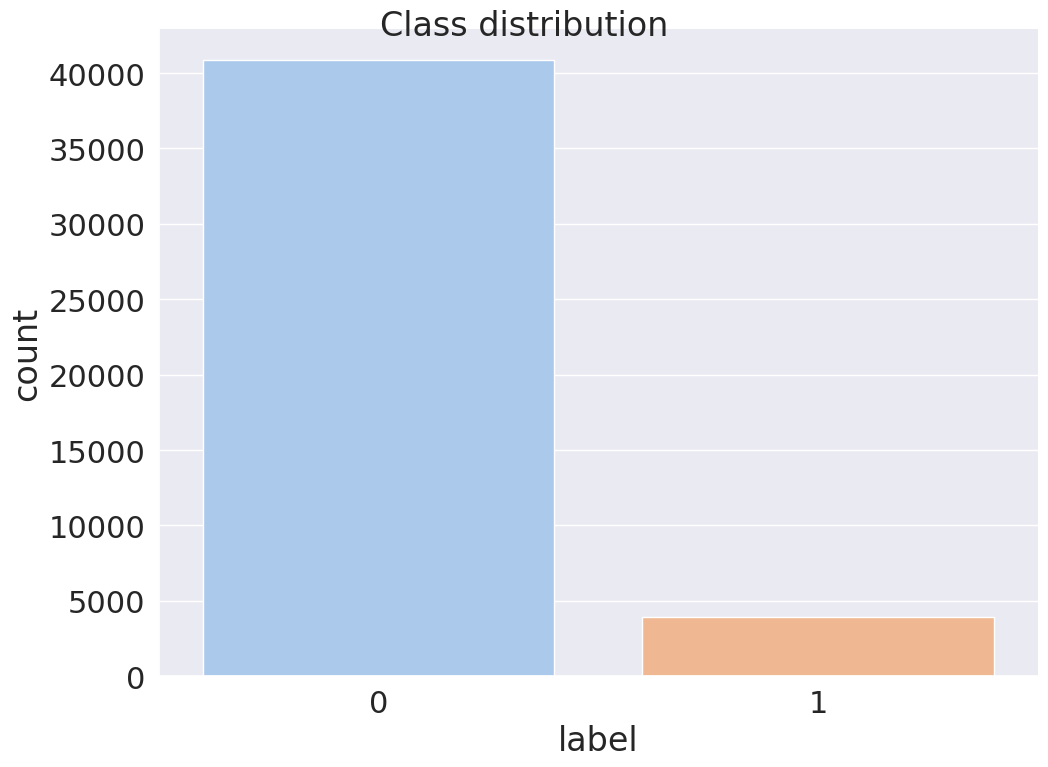

In [8]:
ax = sns.catplot(x="label", data=df, kind="count", palette="pastel", height=8, aspect=11 / 8)

ax.fig.suptitle("Class distribution", fontsize=24, fontdict={"weight": "bold"})

# Featurization

In [9]:
df["js_length"] = df.js.apply(lambda x: len(x))
df["num_spaces"] = df.js.apply(lambda x: x.count(" "))

df["num_parenthesis"] = df.js.apply(lambda x: (x.count("(") + x.count(")")))
df["num_slash"] = df.js.apply(lambda x: x.count("/"))
df["num_plus"] = df.js.apply(lambda x: x.count("+"))
df["num_point"] = df.js.apply(lambda x: x.count("."))
df["num_comma"] = df.js.apply(lambda x: x.count(","))
df["num_semicolon"] = df.js.apply(lambda x: x.count(";"))
df["num_alpha"] = df.js.apply(lambda x: len(re.findall(re.compile(r"\w"), x)))
df["num_numeric"] = df.js.apply(lambda x: len(re.findall(re.compile(r"[0-9]"), x)))

df["ratio_spaces"] = df["num_spaces"] / df["js_length"]
df["ratio_alpha"] = df["num_alpha"] / df["js_length"]
df["ratio_numeric"] = df["num_numeric"] / df["js_length"]
df["ratio_parenthesis"] = df["num_parenthesis"] / df["js_length"]
df["ratio_slash"] = df["num_slash"] / df["js_length"]
df["ratio_plus"] = df["num_plus"] / df["js_length"]
df["ratio_point"] = df["num_point"] / df["js_length"]
df["ratio_comma"] = df["num_comma"] / df["js_length"]
df["ratio_semicolon"] = df["num_semicolon"] / df["js_length"]

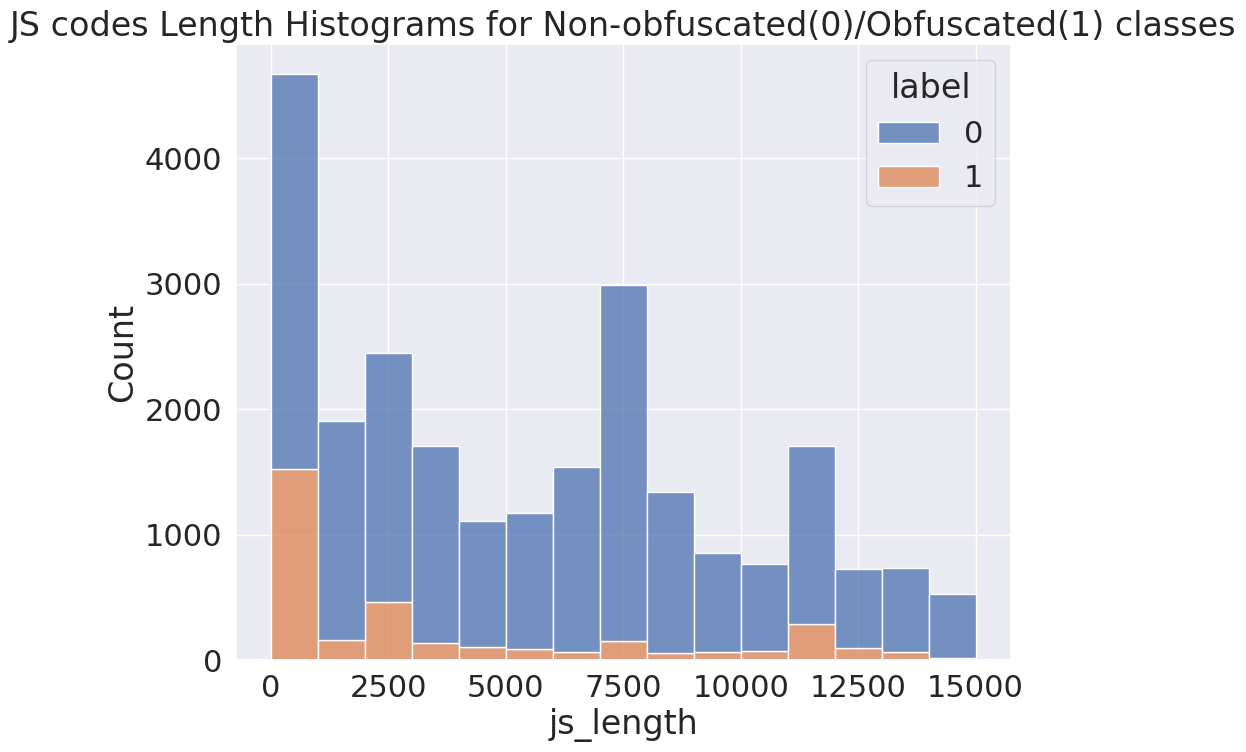

In [10]:
plt.figure(figsize=(10, 8))

sns.histplot(
    data=df,
    x="js_length",
    stat="count",
    hue="label",
    multiple="stack",
    bins=[0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000],
)

plt.title("JS codes Length Histograms for Non-obfuscated(0)/Obfuscated(1) classes")
plt.show()

In [11]:
def entropy(s):
    p, lns = Counter(s), float(len(s))
    return -sum(count / lns * math.log(count / lns, 2) for count in p.values())


df["entropy"] = df.js.apply(lambda x: entropy(x))

print("Mean entropy for obfuscated js:", df["entropy"][df["label"] == 1].mean())
print("Mean entropy for non-obfuscated js:", df["entropy"][df["label"] == 0].mean())

Mean entropy for obfuscated js: 5.273951871026114
Mean entropy for non-obfuscated js: 5.287708702729573


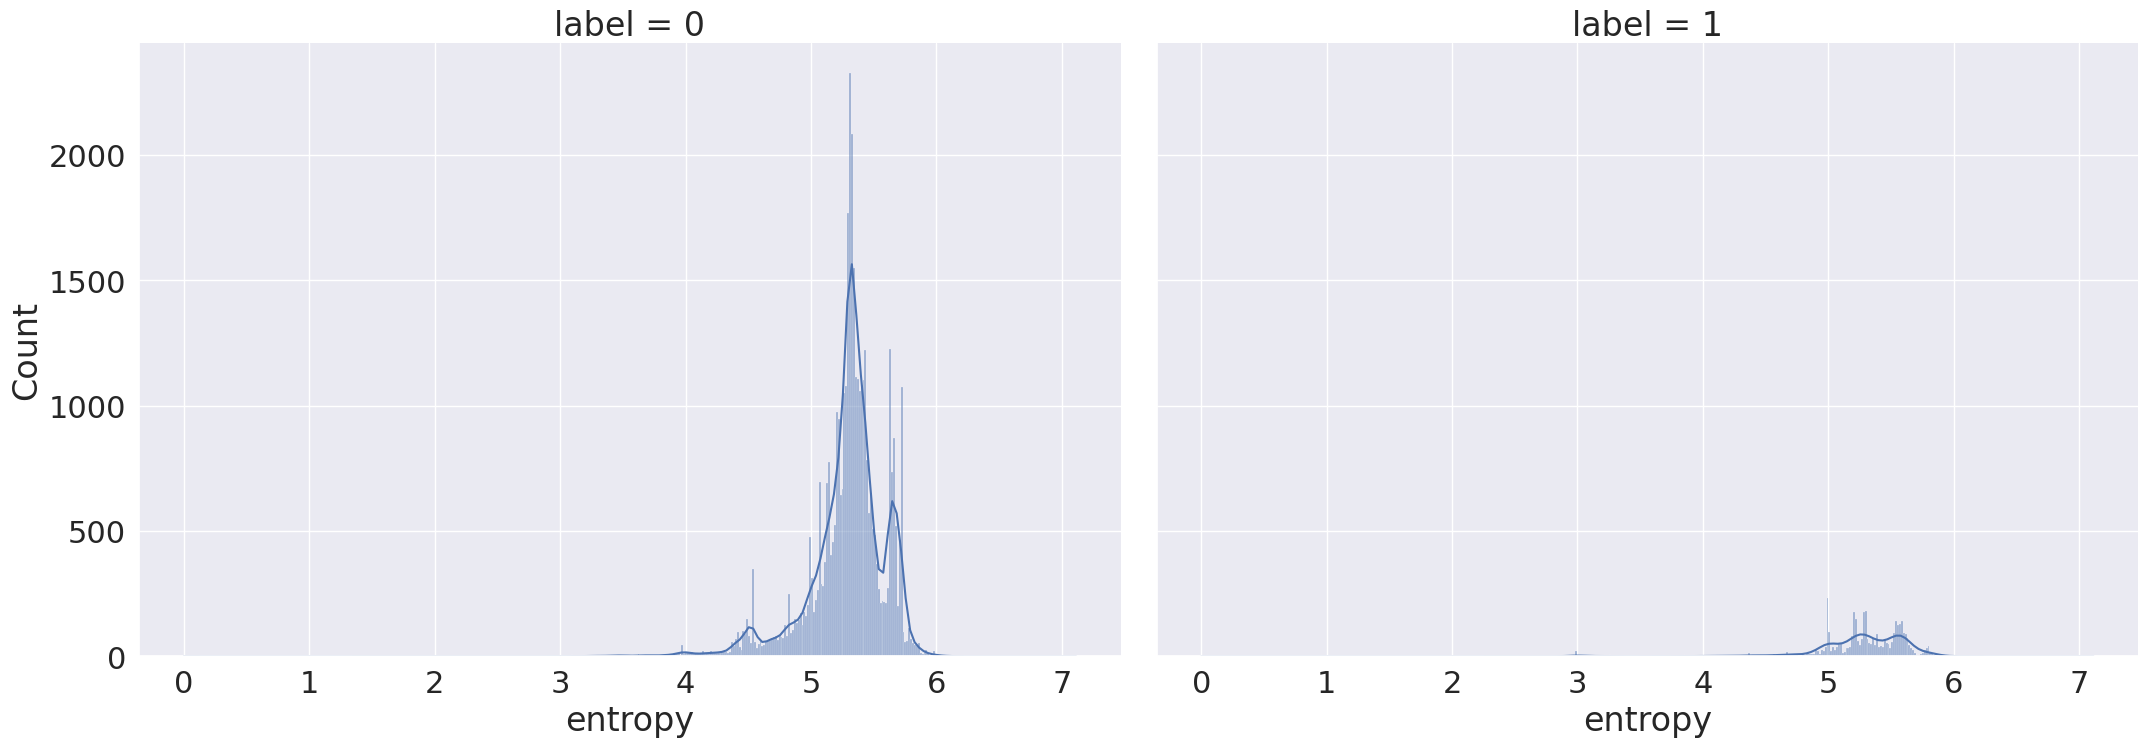

In [12]:
sns.displot(data=df, x="entropy", col="label", kde=True, palette="pastel", height=8, aspect=11 / 8)

In [13]:
# String Operation: substring(), charAt(), split(), concat(), slice(), substr()

df["num_string_oper"] = df.js.apply(
    lambda x: x.count("substring")
    + x.count("charAt")
    + x.count("split")
    + x.count("concat")
    + x.count("slice")
    + x.count("substr")
)

df["ratio_num_string_oper"] = df["num_string_oper"] / df["js_length"]

print("Mean string operations for obfuscated js:", df["num_string_oper"][df["label"] == 1].mean())
print("Mean string operations for non-obfuscated js:", df["num_string_oper"][df["label"] == 0].mean())

Mean string operations for obfuscated js: 2.37822132390096
Mean string operations for non-obfuscated js: 11.277868832407838


In [14]:
# Encoding Operation: escape(), unescape(), string(), fromCharCode()

df["num_encoding_oper"] = df.js.apply(
    lambda x: x.count("escape") + x.count("unescape") + x.count("string") + x.count("fromCharCode")
)

df["ratio_num_encoding_oper"] = df["num_encoding_oper"] / df["js_length"]

print("Mean encoding operations for obfuscated js:", df["num_encoding_oper"][df["label"] == 1].mean())
print("Mean encoding operations for non-obfuscated js:", df["num_encoding_oper"][df["label"] == 0].mean())

Mean encoding operations for obfuscated js: 1.3516927741283475
Mean encoding operations for non-obfuscated js: 11.103647349494851


In [15]:
# URL Redirection: setTimeout(), location.reload(), location.replace(), document.URL(), document.location(), document.referrer()

df["num_url_redirection"] = df.js.apply(
    lambda x: x.count("setTimeout")
    + x.count("location.reload")
    + x.count("location.replace")
    + x.count("document.URL")
    + x.count("document.location")
    + x.count("document.referrer")
)

df["ratio_num_url_redirection"] = df["num_url_redirection"] / df["js_length"]

print("Mean URL redirections for obfuscated js:", df["num_url_redirection"][df["label"] == 1].mean())
print("Mean URL redirections for non-obfuscated js:", df["num_url_redirection"][df["label"] == 0].mean())

Mean URL redirections for obfuscated js: 0.831733198585144
Mean URL redirections for non-obfuscated js: 3.076542968272218


In [16]:
# Specific Behaviors: eval(), setTime(), setInterval(), ActiveXObject(), createElement(), document.write(), document.writeln(), document.replaceChildren()

df["num_specific_func"] = df.js.apply(
    lambda x: x.count("eval")
    + x.count("setTime")
    + x.count("setInterval")
    + x.count("ActiveXObject")
    + x.count("createElement")
    + x.count("document.write")
    + x.count("document.writeln")
    + x.count("document.replaceChildren")
)

df["ratio_num_specific_func"] = df["num_specific_func"] / df["js_length"]

print("Mean specific functions for obfuscated js:", df["num_specific_func"][df["label"] == 1].mean())
print("Mean specific functions for non-obfuscated js:", df["num_specific_func"][df["label"] == 0].mean())

Mean specific functions for obfuscated js: 4.181657402728651
Mean specific functions for non-obfuscated js: 7.338829227720835


# Random Forest

In [17]:
SEED = 42

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    df.iloc[:, 3:], df["label"], stratify=df["label"], test_size=0.2, random_state=SEED
)

In [19]:
clf = RandomForestClassifier(n_estimators=100, random_state=SEED)

# 5-Fold Cross validation
print("Mean accuracy over 5 folds:", np.mean(cross_val_score(clf, X_train, y_train, cv=5)))

Mean accuracy over 5 folds: 0.9552258762696635


In [20]:
clf = RandomForestClassifier(n_estimators=100, random_state=SEED)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9580731489741302


In [21]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

In [22]:
for clf_cls in [
    LinearSVC,
    SVC,
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
]:
    try:
        print(clf_cls.__name__)
        clf = clf_cls(random_state=SEED)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    except Exception as e:
        # print(e)
        print(str(e).split("(")[0])

LinearSVC
Accuracy: 0.6667038358608386
SVC
Accuracy: 0.911685994647636
BaggingClassifier
Accuracy: 0.9555084745762712
RandomForestClassifier
Accuracy: 0.9580731489741302
ExtraTreesClassifier
Accuracy: 0.9574041034790366
AdaBoostClassifier
Accuracy: 0.9228367528991972
GradientBoostingClassifier
Accuracy: 0.9391168599464763


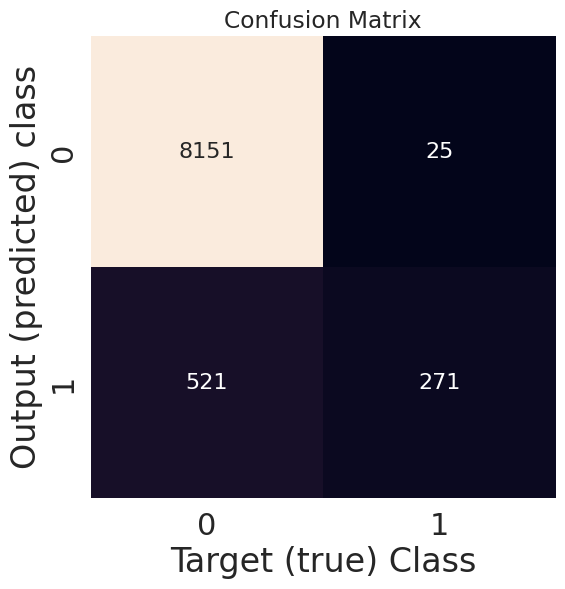

               precision    recall  f1-score   support

non-obfuscted       0.94      1.00      0.97      8176
   obfuscated       0.92      0.34      0.50       792

     accuracy                           0.94      8968
    macro avg       0.93      0.67      0.73      8968
 weighted avg       0.94      0.94      0.93      8968



In [23]:
conf_mat = metrics.confusion_matrix(y_test, y_pred)

plt.subplots(figsize=(6, 6))
sns.set(font_scale=1.4)  # for label size
sns.heatmap(conf_mat, annot=True, fmt=".0f", annot_kws={"size": 16}, cbar=False)  # font size
plt.xlabel("Target (true) Class")
plt.ylabel("Output (predicted) class")
plt.title("Confusion Matrix")
plt.show()

print(metrics.classification_report(y_test, y_pred, target_names=["non-obfuscted", "obfuscated"]))

In [25]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    df.js, df.label, test_size=0.33, random_state=42
)
text_clf = Pipeline(
    [
        ("vect", HashingVectorizer(input="content", ngram_range=(1, 3))),
        ("tfidf", TfidfTransformer(use_idf=True,)),
        ("rf", RandomForestClassifier(class_weight="balanced")),
    ]
)
text_clf.fit(X_train, y_train)

y_test_pred = text_clf.predict(X_test)

print(accuracy_score(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

0.9526255322024735
[[13201   267]
 [  434   895]]
